<h1><center>Projet: Classification de radiographies pulmonaires</center></h1>

<h1>PARTIE 1: Définition de l’objectif du projet</h1>

Mettre en place un modèle prédictif, chargé de classer les radiographies pulmonaires, dans 3 catégories différentes appelées classe.

**Classe covid19**: Pour les patients atteints de la covid19

**Classe normale**: Pour les patients sains

**Classe pneumonie**: Pour les patients atteints de pneumonie virale

<h1>PARTIE 2: Analyse exploratoire de données (EDA)</h1>

<h2><center>Analyse du jeu de données</center></h2>

Le jeu de données brutes, téléchargé sur le site Kaggle, est composé de clichés radiographiques pulmonaires, répartis dans 3 dossiers.

**Dossier COVID-19**: Ce dossier contient les radiographies pulmonaires de patients atteints par la covid 19. 

**Dossier NORMAL**: Ce dossier contient les radiographies pulmonaires de patients sains.

**Dossier Viral Pneumonia**: Ce dossier contient les radiographies pulmonaires de patients atteints de pneumonie virale.

In [1]:
# Pour ignorer les warning
import warnings
warnings.filterwarnings("ignore")

import io
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from math import floor
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm

from matplotlib import offsetbox
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.feature_selection import SelectPercentile


# pre-processing
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

from keras import backend as K
from keras.models import load_model
from tensorflow.keras import callbacks
from keras.layers import Flatten, Dropout, Dense, GlobalAveragePooling2D, InputLayer, Input, AveragePooling2D


# architecture deep learning
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import callbacks
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.layers.convolutional import Conv2D 
from keras.layers.convolutional import MaxPooling2D
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dropout, Dense, GlobalAveragePooling2D, InputLayer, Input

# métrique deep learning
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# transfer learning et extraction de feature
from keras.models import Model
from keras.layers import Input
from keras.applications.vgg16 import VGG16

# évaluation
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Using TensorFlow backend.


### Chargement des radiographies dans un DataFrame

In [2]:
# Chemin d'accès au dossiers contenant les clichés radiographiques
path_directory = r"C:\Users\Desktop\archive\COVID-19 Radiography Database"

# Trouver tous les chemins vers les fichiers qui finissent par .png
liste = glob.glob(path_directory+"\*\*.png")
  
# Extraire le label de chaque image
liste = list(map(lambda x : [x, x.split('\\')[6]], liste))

# Créer un dataframe pandas
data = pd.DataFrame(liste, columns=['filepath', 'nameLabel'])
data['label'] = data['nameLabel'].replace(data['nameLabel'].unique(), [*range(len(data['nameLabel'].unique()))])

# Pour afficher toutes les lignes du dataframe
# pd.set_option('max_rows', 4000)
# pd.set_option('max_columns', 66000)
# data.head()

### Détermination du nombre de radiographies par dossier
L'objectif est de savoir si nous sommes en présence d'un jeu de données équilibré.

In [3]:
df_count=data.groupby("nameLabel").agg({'label':'count'}).reset_index()
df_count

nameLabel  label
0         COVID-19   1143
1           NORMAL   1341
2  Viral Pneumonia   1345

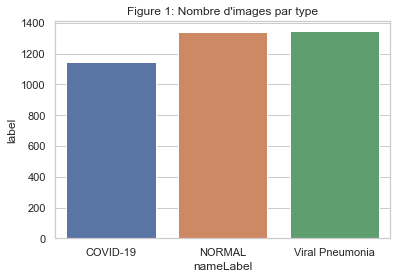

In [4]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x='nameLabel', y='label',data=df_count).set_title("Figure 1: Nombre d'images par type")

La figure ci-dessus montre que le jeu de données, dont nous disposons, est bien équilibré.

<h2><center>Fonctions utiles à l'exploration des données</center></h2>

### Fonction dédiée à la recherche de doublons
Cette fonction affiche les radiographies en doublons présentes dans chaque dossier du jeu de données. Ainsi que les indices des radiographies en doublons.
La moyenne et l'écart-type des niveaux de gris sont calculés pour chaque radiographies.
Les radiographies sont comparées 2 à 2 à partir des paramètres statistiques des niveaux de gris.

In [5]:
def doublon(chemin, taille_dossier):
    
    # Calcul de la moyenne et de l'écart type des niveaux de gris de chaque image
    moyenne=[]
    ecart=[]

    for i in range(1,taille_dossier+1):
    
        image=plt.imread(chemin.format(i))
        image_moyenne=image.mean()
        image_std=image.std()
        moyenne.append(image_moyenne)
        ecart.append(image_std)

        
    # Comparaison de la moyenne et de l'écart type de chaque image, prise 2 à 2
    doublons=0

    for i in range(len(moyenne)-1):
    
        for j in range(i+1,len(moyenne)):
        
            if (moyenne[i]==moyenne[j])&(ecart[i]==ecart[j]):
                
                doublons=doublons+1
            
                plt.figure(figsize=(15,5))
                plt.subplot(121)
                plt.imshow(plt.imread(chemin.format(i+1)),cmap='gray')
                plt.xticks([])
                plt.yticks([])
                plt.title('Radiographie {}'.format(i+1))
            
                plt.subplot(122)
                plt.imshow(plt.imread(chemin.format(j+1)),cmap='gray')
                plt.xticks([])
                plt.yticks([])
                plt.title('Radiographie {}'.format(j+1))
                
                print()
                print("les doublons sont à l'indice",i+1,"et à l'indice",j+1)
    print()    
    print("Le nombre de doublons est de", doublons)

### Fonction déterminant la dimension des radiographies 
Cette fonction affiche la dimension de toutes les radiographies présentes, dans chaque dossier du jeu de données.

In [6]:
def dimension(chemin, taille_dossier):
    for i in range(1,taille_dossier+1):
        image=plt.imread(chemin.format(i))
        print("La dimension de la radiographie ({})".format(i),"est",image.shape)

### Fonction dénombrant le nombre de radiographies par taille
Cette fonction affiche le nombre de radiographies présentant les mêmes dimensions, dans chaque dossier du jeu de données.

In [7]:
def denombrement(chemin, taille_dossier):
    taille=[]

    for i in range(1,taille_dossier+1):
        image=plt.imread(chemin.format(i))
        taille.append(image.shape)
    
    if len(np.unique(np.array(taille)))>1:
        for element in np.unique(np.array(taille)):  
            print("La nombre de radiographie de taille", element, "est", taille.count(element))
    else:
         print("La nombre de radiographie de taille", taille[0], "est", len(taille))

<h2><center>Exploration du dossier COVID-19</center></h2>

### Nombre de radiographies

In [8]:
chemin = path_directory+"\COVID-19\COVID-19 ({}).png"
taille_dossier = len(os.listdir(path_directory+"\COVID-19"))

print('Le dossier COVID-19 contient',taille_dossier,'radiographies.')

Le dossier COVID-19 contient 1143 radiographies.


### Dimensions des radiographies

In [9]:
#dimension(chemin, taille_dossier)

### Dénombrement des radiographies par taille

In [10]:
denombrement(chemin, taille_dossier)

La nombre de radiographie de taille (160, 187, 3) est 1
La nombre de radiographie de taille (197, 253, 3) est 1
La nombre de radiographie de taille (256, 256) est 558
La nombre de radiographie de taille (331, 331) est 583


### Recherche de doublons

In [11]:
doublon(chemin, taille_dossier)


Le nombre de doublons est de 0


<h2><center>Exploration du dossier Normal</center></h2>

### Nombre de radiographies

In [12]:
chemin = path_directory+"/NORMAL/NORMAL ({}).png"
taille_dossier = len(os.listdir(path_directory+"/NORMAL"))

print('Ce dossier contient',taille_dossier,'radiographies.')

Ce dossier contient 1341 radiographies.


### Dimensions des radiographies

In [13]:
#dimension(chemin, taille_dossier)

### Dénombrement des radiographies par taille

In [14]:
denombrement(chemin, taille_dossier)

La nombre de radiographie de taille (1024, 1024) est 1341


### Recherche de doublons


les doublons sont à l'indice 755 et à l'indice 756

Le nombre de doublons est de 1


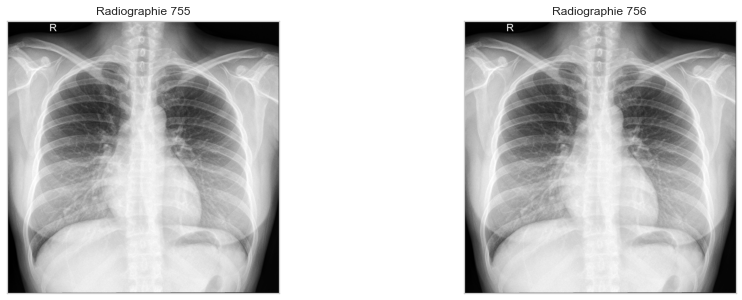

In [15]:
doublon(chemin, taille_dossier)

<h2><center>Exploration du dossier Viral Pneumonia</center></h2>

### Nombre de radiographies

In [16]:
chemin = path_directory+"/Viral Pneumonia/Viral Pneumonia ({}).png"
taille_dossier = len(os.listdir(path_directory+"/Viral Pneumonia"))

print('Ce dossier contient',taille_dossier,'radiographies.')

Ce dossier contient 1345 radiographies.


### Dimensions des radiographies

In [17]:
#dimension(chemin, taille_dossier)

### Dénombrement des radiographies par taille

In [18]:
denombrement(chemin, taille_dossier)

La nombre de radiographie de taille (1024, 1024) est 1205
La nombre de radiographie de taille (1024, 1024, 3) est 140


### Recherche de doublons


les doublons sont à l'indice 74 et à l'indice 75

les doublons sont à l'indice 117 et à l'indice 118

les doublons sont à l'indice 249 et à l'indice 250

les doublons sont à l'indice 294 et à l'indice 295

les doublons sont à l'indice 595 et à l'indice 596

les doublons sont à l'indice 953 et à l'indice 954

les doublons sont à l'indice 1052 et à l'indice 1053

Le nombre de doublons est de 7


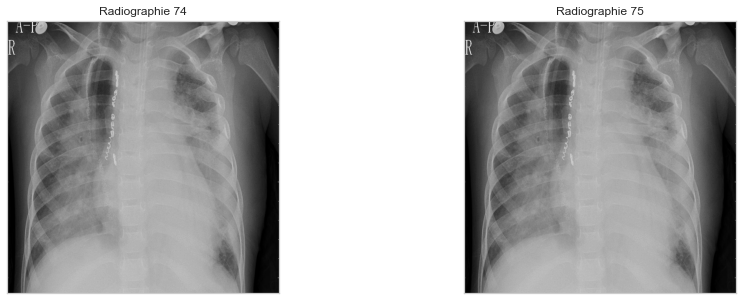

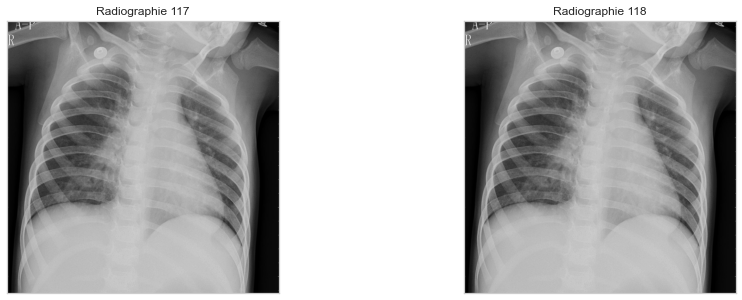

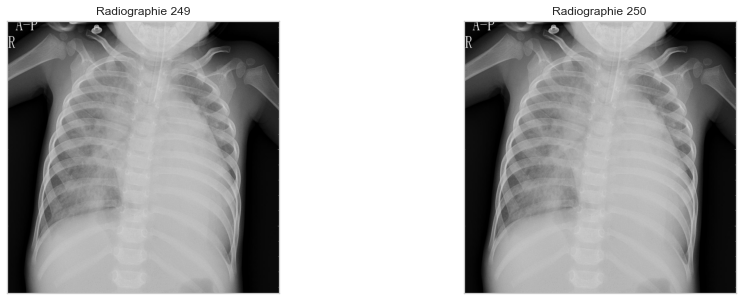

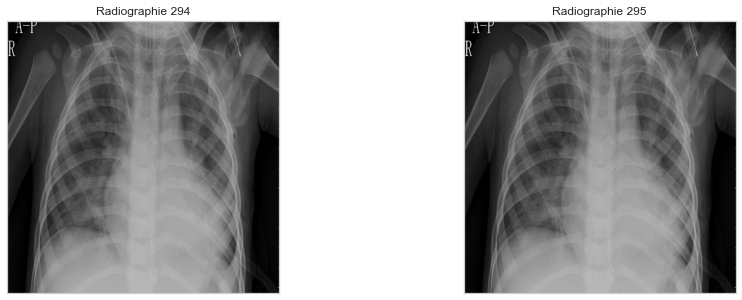

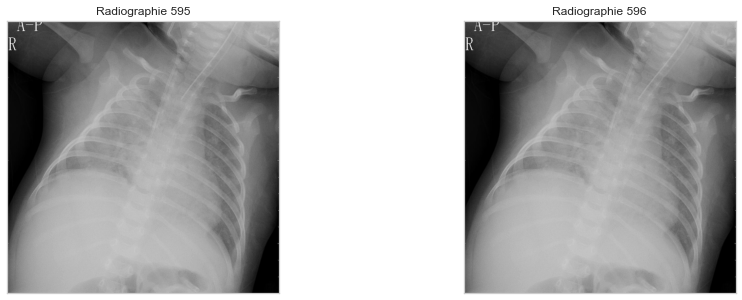

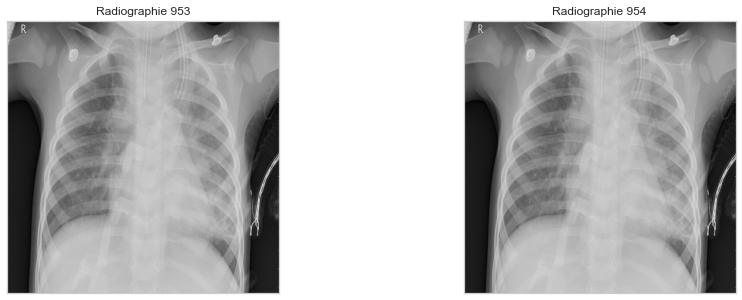

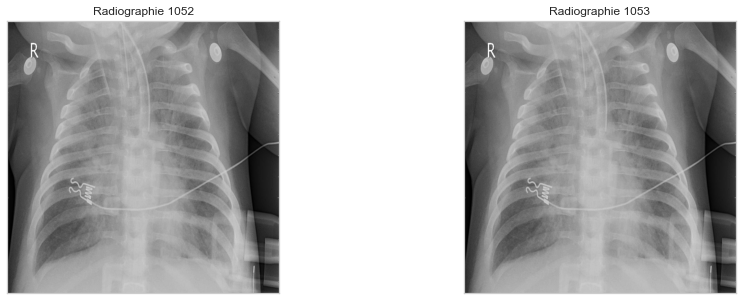

In [19]:
doublon(chemin, taille_dossier)

Les radiographies en doublons sont indentifiées à:
- l'indice 74 et à l'indice 75

- l'indice 117 et à l'indice 118

- l'indice 249 et à l'indice 250

- l'indice 294 et à l'indice 295

- l'indice 595 et à l'indice 596

- l'indice 953 et à l'indice 954

- l'indice 1052 et à l'indice 1053

<h2><center>Analyse détaillée du jeu de données</center></h2>

Dans le jeu de données brut, les radiographies présentent les résolutions suivantes:
* 256x256
* 331x331
* 160x187x3
* 197x253x3
* 1024x1024
* 1024x1024x3

L'objectif de cette partie est de grouper toutes les images dans un dataframe afin de faciliter leur traitement.  
Cette opération nécéssite d'avoir des radiographies de même résolution, celle choisie pour l'ensemble des images est de 256x256. 

### Fonction de redimensionnement d'image

Cette fonction assure le redimensionnement de toutes les radiographies au format 256x256

In [20]:
def image_resize_256(image):
    
    if image.shape == (256,256):
        image_ret = image
        
    else :
        image_ret = cv2.resize(image, dsize = (256,256))
        
    return image_ret

### Analyse visuelle du redimensionnement d'image

Pour estimer l'impact du redimensionnment sur la qualité d'une radiographie, un tirage aléatoire d'une radiographie est réalisé dans le jeu de données.

L'effet du redimensionnement sera interprété qualitativement, après inspection visuelle.

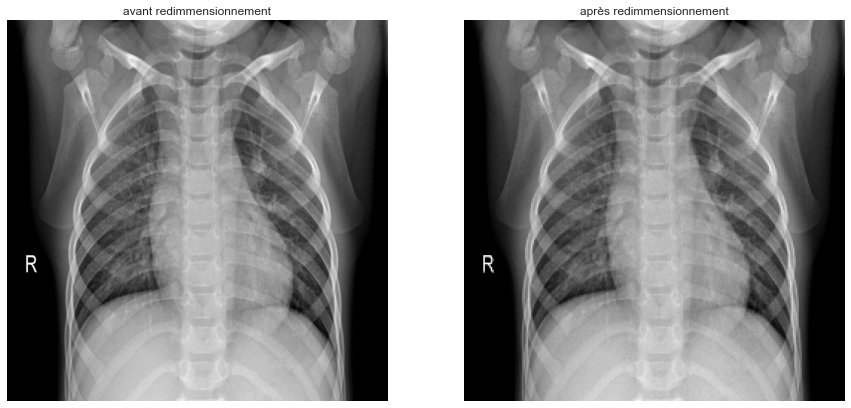

In [21]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
image = plt.imread(data["filepath"][floor(random.uniform(0,1)*data.shape[0])])
plt.imshow(image, cmap='gray')
plt.axis('off');
plt.title("avant redimmensionnement");

plt.subplot(1,2,2)
plt.imshow(image_resize_256(image), cmap='gray')
plt.axis('off');
plt.title("après redimmensionnement");

Visuellement, le redimensionnement n'altère pas la qualité de la radiographie.

### Création d'un dataframe pour analyser les niveaux de gris

Ce dataframe contient les pixels de chaque radiographie mise au format 256x256. Le nombre de colonne de features est donc de 256x256=65536 colonnes

In [22]:
# Extraire le nom de la radiographie
liste = glob.glob(path_directory+"\*\*.png")
liste = list(map(lambda x : [x.split('\\')[6],x.split('\\')[7]], liste))

# Créer un dataframe pandas
df = pd.concat([pd.DataFrame(liste, columns = ['Label','Radiographie']),pd.DataFrame([(image_resize_256(cv2.imread(data['filepath'][k],cv2.IMREAD_GRAYSCALE))).reshape(256*256)for k in range(data.shape[0])])], axis = 1)
df.head()

Label         Radiographie    0    1    2    3    4    5    6    7  ...  \
0  COVID-19     COVID-19 (1).png  175   11    0    0    0    0    0    0  ...   
1  COVID-19    COVID-19 (10).png    0    0   13  103   89   77   61   61  ...   
2  COVID-19   COVID-19 (100).png    4    3    3    2    4    5    6    7  ...   
3  COVID-19  COVID-19 (1000).png  118  118  121  119  121  118  119  118  ...   
4  COVID-19  COVID-19 (1001).png   42   36   30   26   25   25   25   26  ...   

   65526  65527  65528  65529  65530  65531  65532  65533  65534  65535  
0      0      5     22      8      0      1      1      0     20    159  
1     65     59     52     44     34     16      0      0      0      0  
2    192    192    191    191    190    187    184    178    170    166  
3     58     57     59     57     59     58     59     57     56     51  
4    113    109    104    100     94     89     85     79     77     77  

[5 rows x 65538 columns]

### Dataframe contenant les moyennes et les écart type des niveaux de gris des radiographies

Ce dataframe contient les moyennes et les écarts-type des niveaux de gris pour chaque radiographies.

In [23]:
df_stat = pd.concat([df.mean(axis = 1),df.std(axis = 1), df[['Label',"Radiographie"]]], axis = 1).rename({0:"Moyenne", 1:"Ecart-type"},axis = 1).set_index("Radiographie")
df_stat.head()

Moyenne  Ecart-type     Label
Radiographie                                         
COVID-19 (1).png     145.894638   51.837827  COVID-19
COVID-19 (10).png    142.599243   71.452169  COVID-19
COVID-19 (100).png   149.391037   50.553947  COVID-19
COVID-19 (1000).png  149.593735   32.266328  COVID-19
COVID-19 (1001).png  101.355133   17.646837  COVID-19

### Etude de la distribution des moyennes et des écart-types des niveaux de gris 

Le graphique ci-dessous représente la distributions des moyennes et des écarts-types des niveaux de gris pour chaque radiographie.

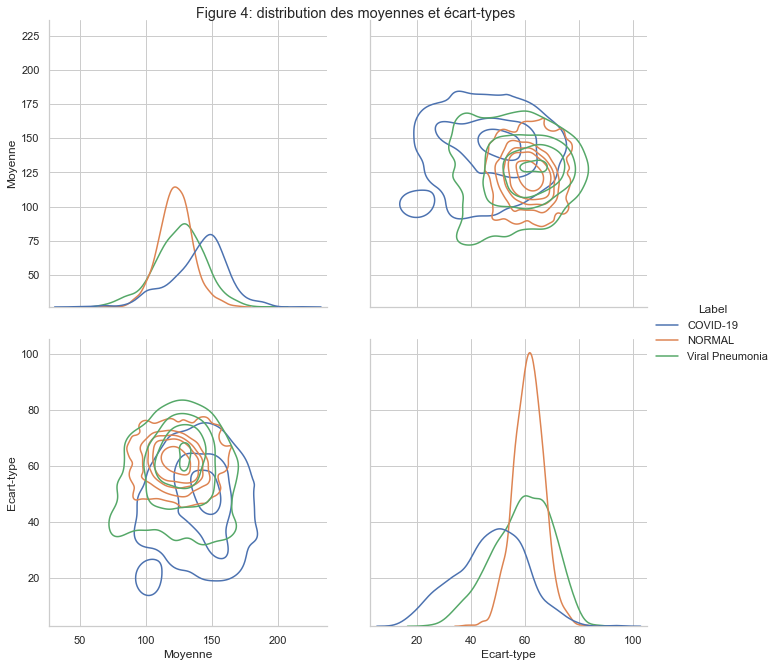

In [24]:
g=sns.PairGrid(data=df_stat, hue="Label");
g.fig.set_size_inches(10,10);
g.map_diag(sns.kdeplot);
g.fig.suptitle("Figure 4: distribution des moyennes et écart-types");
g.map_offdiag(sns.kdeplot, n_levels=6);
g.add_legend();

**Interprétation des courbes**
* La dispersion des  moyennes et des écart-types des niveaux de gris, est importante.  Cette dispersion est plus accentuée pour les images de types COVID-19(en bleu) et Viral Pneumonia(en vert).
* Contrairement aux autres images, les images de type COVID-19(en bleu) ont tendance à avoir une moyenne de niveaux de grix plus élevée et un écart-type de niveaux de grix plus faible. En d'autres termes, les radiographies de type COVID-19(en bleu) sont plus claires et plus homogènes dans les nuances de gris que les radiographies de type Normal(en orange) et Viral Pneumonia(en vert)

Dans la suite du document, une explication sera apportée pour comprendre cette singularité.

# Analyse de l'information contenu dans les radiographies

Les méthodes de filtrage permettent d'identifier les pixels porteurs d'informations. La fonction 'SelectPercentile' selectionne, en noir, les pixels qui contiennent le plus de variance, selon un seuil déterminé.\
Les différents seuils testés sont:
- 90% de variance préservée
- 80% de variance préservée
- 70% de variance préservée
- 60% de variance préservée

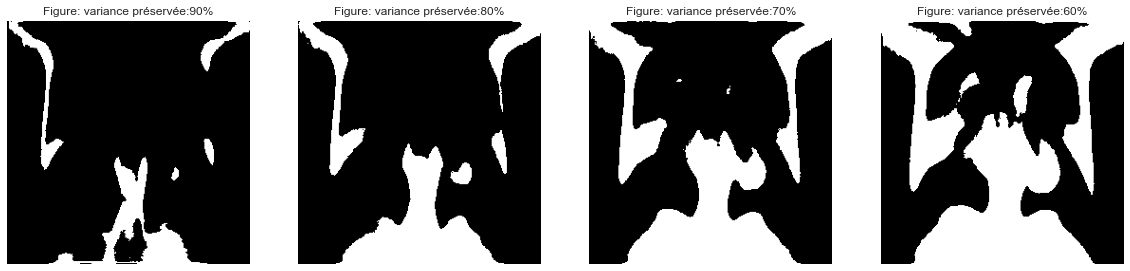

In [25]:
plt.figure(figsize=(20,10))

for i in range(4):
    plt.subplot(1,4,i+1)
    selector = SelectPercentile(percentile=90-10*i)
    selector.fit_transform(df.iloc[:,2:], df["Label"])
    plt.imshow(selector.get_support().reshape(256,256), cmap = 'gray_r');
    plt.title('Figure: variance préservée:{}%'.format(90-10*i))
    plt.axis('off');

Les pixels situés dans la partie inférieure des radiographies ne sont pas porteurs d'informations, cette partie des clichés radiographiques correspond aux coupoles diaphragmatiques qui ne présentent pas d'intérêt dans le cadre de la détection d'une pathologie pulmonaire.

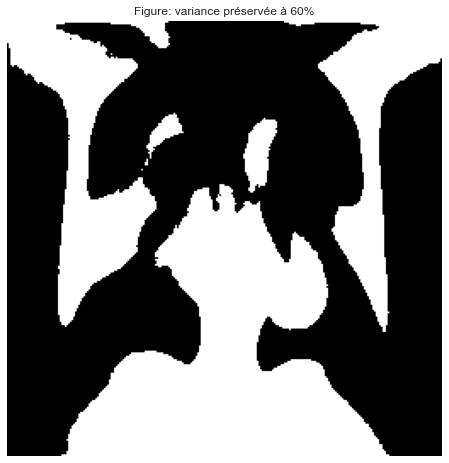

In [26]:
plt.figure(figsize=(12,8))
selector = SelectPercentile(percentile=60)
selector.fit_transform(df.iloc[:,2:], df["Label"])
plt.imshow(selector.get_support().reshape(256,256), cmap = 'gray_r');
plt.title('Figure: variance préservée à 60%')
plt.axis('off');

Les pixels situés sur les bords verticaux des radiographies ne sont pas éliminés, même avec un paramètrage de la variance préservé, fixé à 60%.
Ces pixels sont donc porteurs d'informations, bien que ces parties des clichés radiographiques devraient être en théorie inutiles.

### Visualisation des radiographies dans un espace à 2 dimensions

Une projection des radiographies dans un espace à 2 dimensions, grâce aux algorithmes de Manifold Learning, permet d'obtenir une meilleure distinction visuelle des différentes classes.

In [27]:
model = TSNE(n_components=2)
tsne=model.fit_transform(df.iloc[:,2:])

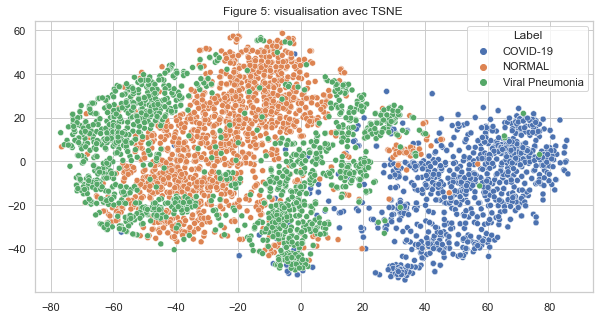

In [28]:
plt.figure(figsize=(10,5))
plt.title("Figure 5: visualisation avec TSNE ")
sns.scatterplot(x=tsne[:,0], y=tsne[:,1], hue=df_stat["Label"], legend="full", cmap='viridis_r');

Les classes NORMAL(en orange) et Viral Pneumonia(en vert) ne sont pas clairement identifiables. Les radiographies de ces 2 classes forment un amas de points dans les parties centrale et supérieure du graphe 2D. Cependant, les radiographies de la classe COVID-19(en bleu) forment un nuage de points, distinct, dans la partie inférieure du graphe 2D. 

Cette visualisation en 2D permet de discriminier la classe COVID-19(en bleu) des autres classes. Les radiographie de type COVID-19 sont linéairement séparables.

### Fonction d'affichage de radiographie sur un graphe 2D
La fonction 'plot_components' affiche quelques images des radiographies appartenant aux différentes classes sur un graphe 2D.

In [29]:
def plot_components(data, model, images=None, ax=None, thumb_frac=0.05, cmap='gray_r', prefit = False):
    ax = ax or plt.gca()
    
    if not prefit :
        proj = model.fit_transform(data)
    else:
        proj = data
    ax.plot(proj[:, 0], proj[:, 1], '.b')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # On ne montre pas le points trop proches
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

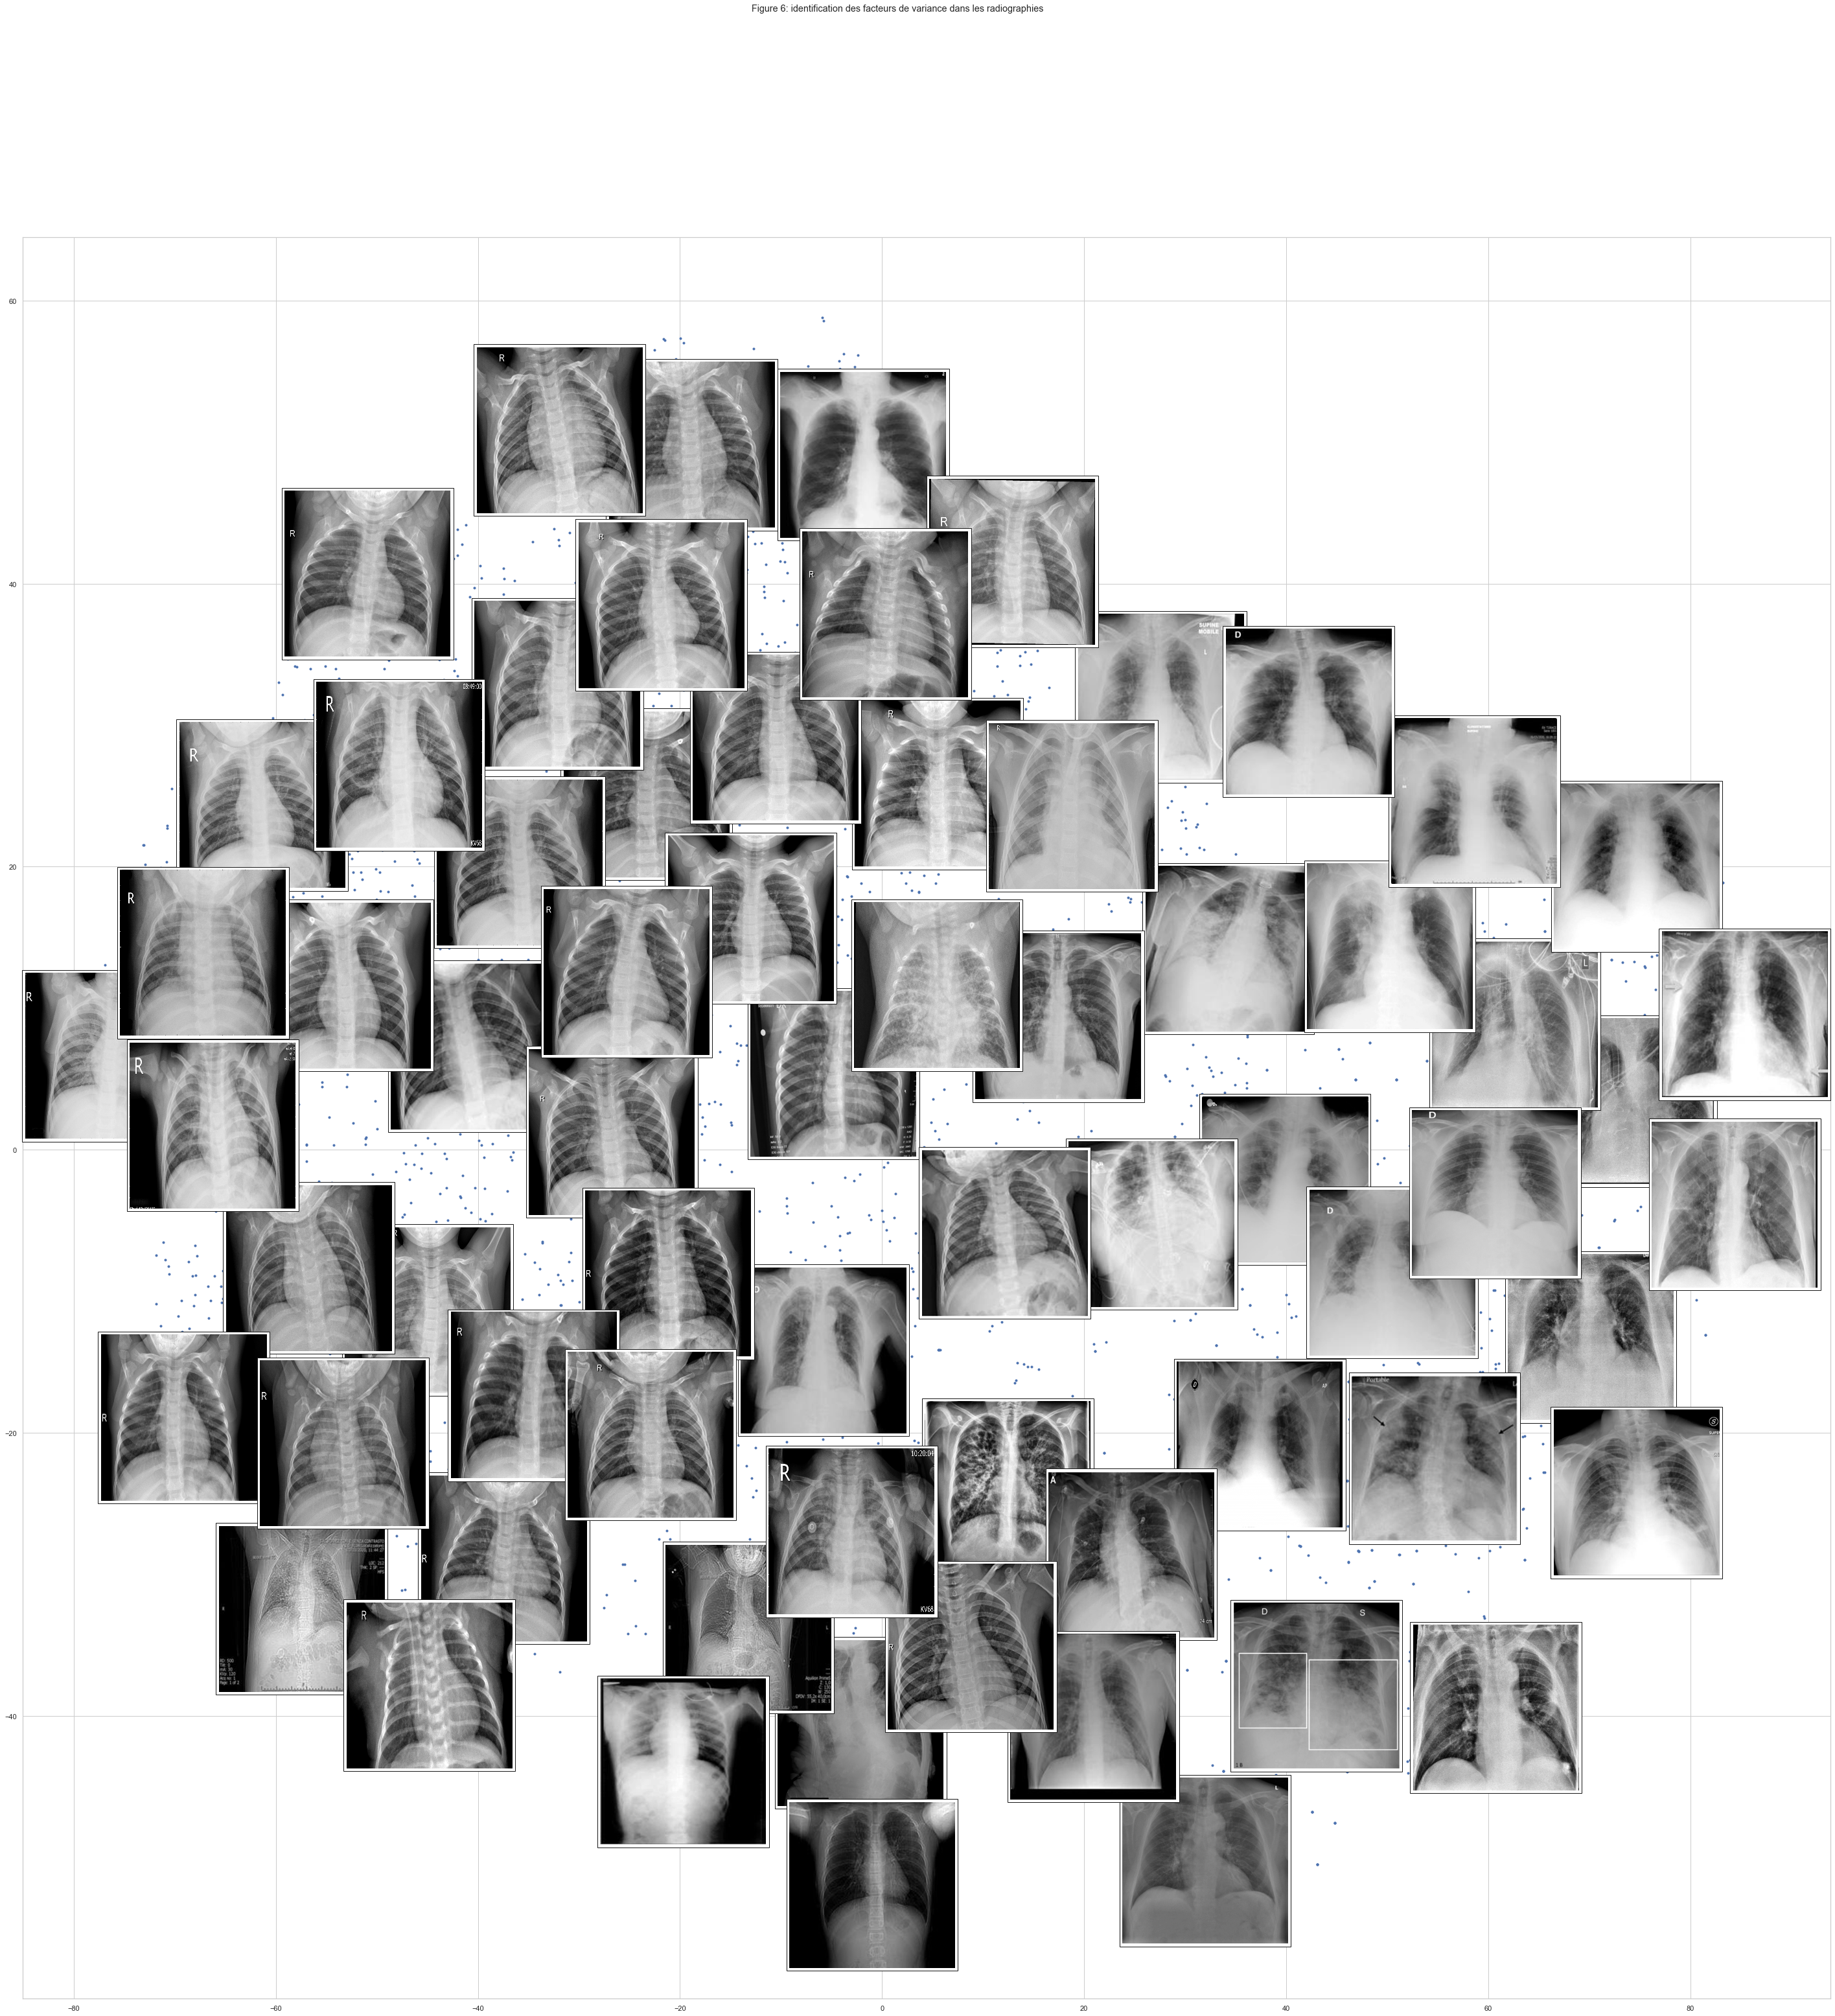

In [30]:
fig, ax = plt.subplots(figsize=(50, 50))
fig.suptitle("Figure 6: identification des facteurs de variance dans les radiographies")
plot_components(tsne, model, np.array(df.iloc[:,2:]).reshape((-1, 256, 256)), cmap = 'gray', thumb_frac = .07, prefit = True);

Interprétation du graphique

* Les radiographies sont plus claires sur la partie droite du graphique.
* Sur la partie gauche du graphique, les images sont plus sombres.
* Les images de type COVID-19 se trouvent à droite du graphique, elles sont caractérisées par une clarté élevée et une absence de bords verticaux noirs.


Ces constatations expliquent les remarques formulées plus haut :
* Pour les images de type COVID-19, les graphes des distributions (voir figure 4) montrent qu'elles ont des moyennes plus élevées et des écart-types  plus faibles. Ceci s'interprète par l'absence des bords noirs, cette absence induit une augumentation du niveau de gris moyen, et une diminution de l'hétérogénéité de l'image et donc de son écart-type de niveau de gris. 
* Les bords verticaux des images (voir figure 5) ne sont pas éliminés lors du filtrage, car ils participent fortement à distinguer les images de type COVID-19, des autres images.

### Visualisation des radiographies dans un espace à 3 dimensions

In [31]:
model = TSNE(n_components=3)
tsne_3D = model.fit_transform(df.iloc[:,2:])

In [32]:
%matplotlib

plt.title("Réduction de dimension avec TSNE 3D ");

fig = plt.figure(figsize = (10, 10));
ax = Axes3D(fig);

x = tsne_3D[:, 0]
y = tsne_3D[:, 1]
z = tsne_3D[:, 2]

ax.set_xlabel("TNSE 1");
ax.set_ylabel("TNSE 2");
ax.set_zlabel("TNSE 3");

sc = ax.scatter(x, y, z, c=pd.get_dummies(df["Label"]));
  
plt.legend(*sc.legend_elements());
plt.legend(['COVID-19', 'NORMAL', 'Viral Pneumonia']);

Using matplotlib backend: Qt5Agg


La visualisation en 3D apporte une valeur ajoutée par rapport à la visualisation en 2D.  

En modulant l'angle de vue, on observe toujours une distinction de la classe Covid-19 mais surtout, une meilleure séparation des deux autres classes (NORMAL et Viral Pneumonia). 

### CONCLUSION

La visualisation des données a permis de constater que les radiographies de type COVID-19 diffèrent des autres images.
Elles sont caractérisées par une absence de bords noirs verticaux, résultant probablement d'un zoom effectué par les émetteurs de ces radiographies.  
Cette caractéristique risque d'induire en erreur un modèle prédictif, qui se baserait sur une reconnaissance liée à celle-ci.

La partie Datavisualisation a permis l'identification d'un biais sur les radiographies.
En effectuant un tirage aléatoire, dans chacune des catégories de radiographie, on constate que les clichés, de type NORMAL et PNEUMONIE, présentent des bandes noires sur les cotés.

In [33]:
def affichage_radio(df):
    plt.figure(figsize=(20,8))
    
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.imshow(plt.imread(df["filepath"][df["label"]==i].reset_index(drop=True)[floor(random.uniform(0,1)*(df["filepath"][df["label"]==i].reset_index(drop=True)).shape[0])]), cmap='gray');
        plt.title(df["nameLabel"][df["label"]==i].reset_index(drop=True)[floor(random.uniform(0,1)*(df["filepath"][df["label"]==i].reset_index(drop=True)).shape[0])])
        plt.axis("off");

In [34]:
affichage_radio(data)

Il est possible de corriger ces différences en effectuant des transformations morphologiques, pour éliminer les bords noirs verticaux sur toutes les radiographies. Ainsi, le modèle se concentrera uniquement sur les différences de caractéristiques aux niveaux des poumons. 

<h1>PARTIE 3: DATA-PREPROCESSING</h1>

L'application d'un traitement d'image peut atténuer le biais induit par la présence de bords noirs verticaux.
L'idée sous-jacente, est de réaliser un «zoom» sur les radiographie NORMAL et PNEUMONIE.
La solution retenue, préconise l'élimination des bords latéraux, inférieurs et supérieurs, afin de se focaliser sur l'information utile, les poumons.

### Création des dossiers et sous dossiers

In [35]:
path = r'C:\Users\Desktop'

In [37]:
# création des dossiers contenant les radiographies redimensionnées
os.mkdir(path + r'\Projet_covid_19')
os.mkdir(path + r'\Projet_covid_19\Radiographie')
os.mkdir(path + r'\Projet_covid_19\Radiographie\Covid')
os.mkdir(path + r'\Projet_covid_19\Radiographie\Normal')
os.mkdir(path + r'\Projet_covid_19\Radiographie\Pneumonie')
         
# création des dossiers contenant les radiographies utilisées pour la phase de test
os.mkdir(path + r'\Projet_covid_19\Test')
os.mkdir(path + r'\Projet_covid_19\Test\Covid')
os.mkdir(path + r'\Projet_covid_19\Test\Normal')
os.mkdir(path + r'\Projet_covid_19\Test\Pneumonie')

# création des dossiers contenant la sauvegarde du modèle et des résultats
os.mkdir(path + r'\Projet_covid_19\Sauvegarde')

<h2><center>Fonctions utiles aux Data-preprocessing</center></h2>

### Fonction de transformation morphologique

In [38]:
def transfo_morpho(classe):
    liste = glob.glob(path_directory+"/{}/*".format(classe))

    plt.figure(figsize=(15,6))

    plt.subplot(121)
    radio=plt.imread(liste[(floor(random.uniform(0,1)*len(liste)))])
    plt.imshow(radio,cmap='gray');
    plt.axis('off')
    plt.title("avant zoom");

    # l'image est rogné de 20% sur la longueur et la largeur
    plt.subplot(122)
    long, larg = radio.shape[:2]
    long_z = int(0.8*long)
    larg_z = int(0.8*larg)
    long_deb = int(0.1*larg)
    larg_deb = int(0.1*larg)
    img_zoom = radio[long_deb:long_deb + long_z, larg_deb:larg_deb + larg_z]
    img_zoom = cv2.resize(img_zoom, dsize = (224,224))
    plt.imshow(img_zoom,cmap='gray')
    plt.axis('off')
    plt.title("après zoom");

### Fonction de traitement et de sauvegarde des radiographies de type COVID-19

In [39]:
def transfo_covid_save(old_classe, new_classe):
    liste = glob.glob(path_directory+"/{}/*".format(old_classe))

    for i,radio in enumerate(liste):
        radio = plt.imread(radio)
    
        if radio.mean()<0.5:
            long, larg = radio.shape[:2]
            long_z = int(0.8*long)
            larg_z = int(0.8*larg)
            long_deb = int(0.1*larg)
            larg_deb = int(0.1*larg) 
            img_zoom = radio[long_deb:long_deb + long_z, larg_deb:larg_deb + larg_z]
            img_zoom = cv2.resize(img_zoom, dsize = (224,224))
            image = Image.fromarray((img_zoom*255).astype(np.uint8))
            chaine = f'\Projet_covid_19\Radiographie\{new_classe}\{new_classe}_{i+1}.png'
            image.save(path+chaine)
    
        else:
            img_zoom = cv2.resize(radio, dsize = (224,224))
            image = Image.fromarray((img_zoom*255).astype(np.uint8))
            chaine = f'\Projet_covid_19\Radiographie\{new_classe}\{new_classe}_{i+1}.png'
            image.save(path+chaine)

### Fonction de traitement et de sauvegarde des radiographies de type Normal et Pneumonie

In [40]:
def transfo_save(old_classe, new_classe):
    liste = glob.glob(path_directory+"/{}/*".format(old_classe))

    for i,radio in enumerate(liste):
        radio = plt.imread(radio)
        long, larg = radio.shape[:2]
        long_z = int(0.8*long)
        larg_z = int(0.8*larg)
        long_deb = int(0.1*larg)
        larg_deb = int(0.1*larg) 
        img_zoom = radio[long_deb:long_deb + long_z, larg_deb:larg_deb + larg_z]
        img_zoom = cv2.resize(img_zoom, dsize = (224,224))
        image = Image.fromarray((img_zoom*255).astype(np.uint8))
        chaine = f'\Projet_covid_19\Radiographie\{new_classe}\{new_classe}_{i+1}.png'
        image.save(path+chaine)

### Traitement et sauvegarde des radiographies "Covid-19"

In [41]:
transfo_covid_save('COVID-19', 'Covid')

### Traitement et sauvegarde des radiographies "Normal"

In [42]:
transfo_save('Normal', 'Normal')

### Traitement et sauvegarde des radiographies "Pneumonie"

In [43]:
transfo_save('Viral Pneumonia', 'Pneumonie')

### Effet de la transformation morphologique sur les radiographies de type "Pneumonie"

In [44]:
transfo_morpho('Viral Pneumonia')

La figure monte que l'élimination des bords de l'image, supprime les informations parasites(la lettre R à gauche) présentes en périphérie des radiographies et focalise l'attention sur la partie centrale des clichés qui porte le plus d'information.

### Création d'une base de données contenant les radiographies de test

In [45]:
import shutil, os

for i in range(10):
    liste = glob.glob(path + r'\Projet_covid_19\Radiographie\Covid\*')
    indice = floor(random.uniform(0,1)*len(liste))
    # déplacement de la radiographie dans un autre dossier
    shutil.move(path + r'\Projet_covid_19\Radiographie\Covid\Covid_{}.png'.format(indice), path + r'\Projet_covid_19\Test\Covid\Covid_{}.png'.format(indice))

In [46]:
for i in range(10):
    liste = glob.glob(path + r'\Projet_covid_19\Radiographie\Normal\*')
    indice = floor(random.uniform(0,1)*len(liste))
    # déplacement de la radiographie dans un autre dossier
    shutil.move(path + r'\Projet_covid_19\Radiographie\Normal\Normal_{}.png'.format(indice), path + r'\Projet_covid_19\Test\Normal\Normal_{}.png'.format(indice))

In [47]:
for i in range(10):
    liste = glob.glob(path + r'\Projet_covid_19\Radiographie\Pneumonie\*')
    indice = floor(random.uniform(0,1)*len(liste))
    # déplacement de la radiographie dans un autre dossier
    shutil.move(path + r'\Projet_covid_19\Radiographie\Pneumonie\Pneumonie_{}.png'.format(indice), path + r'\Projet_covid_19\Test\Pneumonie\Pneumonie_{}.png'.format(indice))

### Création d'une base de données contenant les radiographies d'entrainement

In [48]:
# Trouver tous les chemins vers les fichiers qui finissent par .png
liste = glob.glob(r"C:\Users\Desktop\Projet_covid_19\Radiographie\*\*.png")

# Extraire le label de chaque image
liste = list(map(lambda x : [x, x.split('\\')[6]], liste))

# Créer un dataframe pandas
df1 = pd.DataFrame(liste, columns=['filepath', 'nameLabel'])
df1['label'] = df1['nameLabel'].replace(df1['nameLabel'].unique(), [*range(len(df1['nameLabel'].unique()))])

<h1>PARTIE 4: MODELISATION</h1>

### Identification des variables et de la target

In [50]:
# features contient les chemins d'accès au radiographies
features=df1["filepath"]

# target contient les labels des radiographies
target=df1["label"]

### Séparation du jeu des données 
Le jeu de données est divisé de telle manière:
- 80% des radiographies utilisées pour l'entrainement du modèle
- 20% des radiographies utilisées pour tester le modèle

In [51]:
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.8, random_state=0)

### Création de la base de données d'entrainement

In [52]:
X_train = pd.DataFrame(X_train)
X_train = list(map(lambda x : [x, x.split('\\')[6]], X_train["filepath"]))

In [53]:
data_train = pd.DataFrame(X_train, columns=['filepath', 'nameLabel'])
data_train['label'] = data_train['nameLabel'].replace(data_train.nameLabel.unique(), [*range(len(data_train.nameLabel.unique()))])

### Création de la base de données de test

In [54]:
X_test=pd.DataFrame(X_test)

In [55]:
X_test = list(map(lambda x : [x, x.split('\\')[6]], X_test["filepath"]))

In [56]:
data_test = pd.DataFrame(X_test, columns=['filepath', 'nameLabel'])
data_test['label'] = data_test['nameLabel'].replace(data_train.nameLabel.unique(), [*range(len(data_train.nameLabel.unique()))])

<h2>Augmentation d'image</h2>

Cette modélisation fait appel à la technique d'augmentation d'image qui permet d'enrichir le jeu de données et de réduire le phénomène d'overfitting. 

In [57]:
# tirage aléatoire d'une radiographie dans le jeu de données
data = cv2.imread(df1['filepath'][100])

### Transformation morphologique: flip horizontal
Cette transformation morphologique d'image permet un retournement horizontal de  l'image.

In [58]:
datagen=ImageDataGenerator(horizontal_flip=True)

generator=datagen.flow(expand_dims(data,0), batch_size=1)

plt.figure(figsize=(20,10))
for i in range(2):
    plt.subplot(1,2,i+1)
    batch=generator.next()
    image=batch[0].astype('uint8')
    plt.imshow(image)
    plt.axis('off')

### Transformation morphologique: rotation de 90° maximum
Cette transformation morphologique d'image permet une rotation de l'image d'un angle de 90° maximum vers la gauche ou vers la droite

In [59]:
datagen=ImageDataGenerator(rotation_range = 90)

generator=datagen.flow(expand_dims(data,0), batch_size=1)

plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(1,4,i+1)
    batch=generator.next()
    image=batch[0].astype('uint8')
    plt.imshow(image)
    plt.axis('off')

### Transformation morphologique: agrandissement de 10 % maximum
Cette transformation morphologique d'image permet un agrandissement de l'image de 10% maximum

In [60]:
datagen=ImageDataGenerator(zoom_range=0.1)

generator=datagen.flow(expand_dims(data,0), batch_size=1)

plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(1,4,i+1)
    batch=generator.next()
    image=batch[0].astype('uint8')
    plt.imshow(image)
    plt.axis('off')

### Création du générateur d'image

In [61]:
train_data_generator = ImageDataGenerator(
    rescale = 1./255,        # normalisation des images d'entrainement
    rotation_range = 10,     # rotation des images d'un angle de 10° maximum
    zoom_range = 0.1,        # agrandissement des images de 10% maximum
    horizontal_flip = True,  # retournement horizontal de l'image
    validation_split = 0.25  # 75% des images serviront à l'entrainement du modèle et 25% serviront à la validation 
)

test_data_generator = ImageDataGenerator(
    rescale = 1./255        # normalisation des images de test
)   

### Générateur des données d'entrainement

In [62]:
data_train["label"] = data_train["label"].astype(str)

train_generator = train_data_generator.flow_from_dataframe(
    dataframe=data_train, 
    x_col='filepath',
    y_col='label',
    shuffle=True,
    class_mode='categorical',
    subset='training'   
)

Found 2280 validated image filenames belonging to 3 classes.


### Générateur des données de validation

In [63]:
data_train["label"] = data_train["label"].astype(str)

valid_generator = train_data_generator.flow_from_dataframe(
    dataframe=data_train, 
    x_col='filepath',
    y_col='label',
    shuffle=True,
    class_mode='categorical',
    subset='validation'
)

Found 759 validated image filenames belonging to 3 classes.


### Générateur des données de test

In [64]:
data_test["label"] = data_test["label"].astype(str)

test_generator = test_data_generator.flow_from_dataframe(
    dataframe=data_test, 
    x_col='filepath',
    y_col=None,
    class_mode=None,
    shuffle=False
)

Found 760 validated image filenames.


### Mise en place du modèle pré-entrainé VGG16

Cette modélisation est basé sur le principe du transfer learning qui consiste à utiliser un modèle pré-entrainé sur des centaines de milliers d'images.
VGG16, un modèle pré-entrainé, est utlisé pour extraire les caractéristiques des radiographies. 

In [65]:
base_model = VGG16(input_shape = (256, 256, 3), weights = 'imagenet', include_top = False)

### Couches de convolution de VGG16  "freezer"
Dans un premier temps, les couches de convolution du modèle VGG16 sont gelées.
Seule la couche de réseaux de neurones entièrement connectées sera entrainé pour effectuer la classification des radiographies.

In [66]:
for layer in base_model.layers:
    layer.trainable = False 

### Résumé du modèle pré entrainé VGG16
Le modèle VGG16 est constitué d'une alternance de couche de convolution et de max pooling.

In [67]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

### Architecture du modèle

La classification est assurée en sortie du modèle VGG16, par une couche dense de réseau de neurones entièrement connectés.
Les couches de dropout sont utiles pour éviter le phénomène d'overfitting.

In [68]:
# modèle pré-entrainé VGG16
new_model = base_model.output

# couche de neurone complètement connéctés
new_model = GlobalAveragePooling2D()(new_model)

new_model = Dense(1024,activation = 'relu')(new_model)
new_model = Dropout(0.4)(new_model)
new_model = Dense(512,activation = 'relu')(new_model)
new_model = Dropout(0.4)(new_model)
new_model = Dense(3, activation = "softmax")(new_model)

model = Model(inputs = base_model.input, outputs = new_model)

### Compilation du modèle
Le modèle est compilé avec une fonction d'optimisation de type 'adam', une fonction de perte 'categorical crossentropy' adaptée au problème de classification et une métrique 'accuracy' qui mesure le taux de bonnes prédictions.

In [69]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### Entrainement du modèle
Le modèle est entrainé sur 10 epochs et une taille de batch égale à 32

In [70]:
epoch = 10
batch_size = 32

history = model.fit_generator(
    generator = train_generator,
    epochs = epoch,
    steps_per_epoch = train_generator.samples//batch_size,
    validation_data = valid_generator,
    validation_steps = valid_generator.samples//batch_size
)

Epoch 1/10
71/71 [==============================] - 37s 523ms/step - loss: 0.6880 - accuracy: 0.6757 - val_loss: 0.3577 - val_accuracy: 0.8533
Epoch 2/10
71/71 [==============================] - 31s 441ms/step - loss: 0.3615 - accuracy: 0.8519 - val_loss: 0.2103 - val_accuracy: 0.9230
Epoch 3/10
71/71 [==============================] - 31s 434ms/step - loss: 0.3169 - accuracy: 0.8839 - val_loss: 0.2339 - val_accuracy: 0.8336
Epoch 4/10
71/71 [==============================] - 30s 426ms/step - loss: 0.2643 - accuracy: 0.8990 - val_loss: 0.4952 - val_accuracy: 0.8996
Epoch 5/10
71/71 [==============================] - 30s 423ms/step - loss: 0.2829 - accuracy: 0.8932 - val_loss: 0.1466 - val_accuracy: 0.9202
Epoch 6/10
71/71 [==============================] - 30s 421ms/step - loss: 0.2594 - accuracy: 0.9010 - val_loss: 0.1686 - val_accuracy: 0.9106
Epoch 7/10
71/71 [==============================] - 29s 410ms/step - loss: 0.2455 - accuracy: 0.9033 - val_loss: 0.2058 - val_accuracy: 0.9243

### Fine Tuning
Le fine tuning permet d'adapter 4 les dernières couches de convolutions du modèles pré-entrainé, à nos données. Ce réglage fin permet une meilleur extraction des caractéristiques des radiographies. 

### 'Unfreeze' des 4 dernières couches de convolutions de VGG16

In [71]:
for layer in base_model.layers[-4:]:
    layer.trainable = True

### Ajout d'un callback
Afin d'optimiser la convergence du modèle, un callback permet de réduire le learning rate toutes les 10 epochs.

In [72]:
def decreasinglrUpdate(epoch,learning_rate):
    if epoch % 10 == 0:
        return learning_rate * 0.5
    else: 
        return learning_rate
    
lrScheduler = callbacks.LearningRateScheduler(schedule = decreasinglrUpdate, verbose = 1)

### Nouvelle compilation du modèle

In [73]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### Nouvel entrainement du modèle

In [74]:
epoch = 50
batch_size = 32

history = model.fit_generator(
    generator = train_generator,
    epochs = epoch,
    steps_per_epoch = train_generator.samples//batch_size,
    validation_data = valid_generator,
    validation_steps = valid_generator.samples//batch_size,  
    callbacks = [lrScheduler]
) 

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
71/71 [==============================] - 29s 406ms/step - loss: 2.3136 - accuracy: 0.7015 - val_loss: 0.5694 - val_accuracy: 0.8573
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
71/71 [==============================] - 31s 443ms/step - loss: 0.3570 - accuracy: 0.8652 - val_loss: 0.0888 - val_accuracy: 0.9051
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
71/71 [==============================] - 31s 436ms/step - loss: 0.2929 - accuracy: 0.8848 - val_loss: 0.1072 - val_accuracy: 0.9065
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0005000000237487257.
71/71 [==============================] - 32s 453ms/step - loss: 0.2329 - accuracy: 0.9159 - val_loss: 0.2239 - val_accuracy: 0.9477
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0005000000237

Epoch 37/50

Epoch 00037: LearningRateScheduler reducing learning rate to 6.25000029685907e-05.
71/71 [==============================] - 27s 377ms/step - loss: 0.0318 - accuracy: 0.9875 - val_loss: 0.0038 - val_accuracy: 0.9725
Epoch 38/50

Epoch 00038: LearningRateScheduler reducing learning rate to 6.25000029685907e-05.
71/71 [==============================] - 26s 372ms/step - loss: 0.0306 - accuracy: 0.9911 - val_loss: 0.3277 - val_accuracy: 0.9574
Epoch 39/50

Epoch 00039: LearningRateScheduler reducing learning rate to 6.25000029685907e-05.
71/71 [==============================] - 27s 374ms/step - loss: 0.0260 - accuracy: 0.9921 - val_loss: 0.1625 - val_accuracy: 0.9629
Epoch 40/50

Epoch 00040: LearningRateScheduler reducing learning rate to 6.25000029685907e-05.
71/71 [==============================] - 26s 364ms/step - loss: 0.0365 - accuracy: 0.9874 - val_loss: 0.0304 - val_accuracy: 0.9574
Epoch 41/50

Epoch 00041: LearningRateScheduler reducing learning rate to 3.125000148429

### Génération des prédictions du modèle

In [75]:
test_generator.reset()

# y_pred récupère les labels des prédictions
y_pred = np.argmax(model.predict(test_generator), axis = 1)

# y_test contient les labels des radiographies de test
y_test = data_test["label"].astype(int)

<h1>PARTIE 5: EVALUATION</h1>

<h2><center>Fonction d'affichage des résultats</center></h2>

### Matrice de confusion
Cette fonction permet l'affichage et la sauvegarde de la matrice de confusion

In [76]:
def matrice_confusion(y_pred, y_test):
    
    cm = confusion_matrix(y_test, y_pred)
   
    # affichage de la matrice de confusion
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest',cmap='Blues')
    plt.title("Matrice de confusion")
    
    tick_marks = np.arange(len(list(df1['nameLabel'].unique())))
    plt.xticks(tick_marks, list(df1['nameLabel'].unique()))
    plt.yticks(tick_marks, list(df1['nameLabel'].unique()))
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment = "center", color="white" if cm[i, j] > ( cm.max() / 2) else "black")
    plt.ylabel('Vrais labels')
    plt.xlabel('Labels prédits')
    plt.savefig(path+"\Projet_covid_19\Sauvegarde\matrice_confusion.png");

### Rapport de classication

Cette fonction permet l'affichage et la sauvegarde du rapport de classification

In [77]:
def rapport_classification(y_pred, y_test):
    
    report = classification_report(y_test, y_pred, target_names=list(df1['nameLabel'].unique()))
    print(report)
    file = open(path+"\Projet_covid_19\Sauvegarde\classification_report.txt", "w")
    file.write(report)
    file.close()

### Précision et perte
Cette fonction permet l'affichage et la sauvegarde des courbes de précision et de perte sur les données d'entrainement et sur les données de test.

In [78]:
def precision_perte(history):
    
    train_acc = history.history["accuracy"]
    valid_acc = history.history["val_accuracy"]
    
    plt.figure(figsize=(20,8))
    
    # affichage des fonctions de précision sur les données d'entrainement et de test
    plt.subplot(1,2,1)
    plt.plot(np.arange(1,len(train_acc)+1), train_acc)
    plt.plot(np.arange(1,len(train_acc)+1), valid_acc)
    plt.legend(["Training Accuracy", "Validation Accuracy"])
    plt.title("Training et Validation Accuracy ")
    plt.grid()
    plt.xlim([1,len(train_acc)]);
    plt.xlabel("Epoch");
    
    # affichage des fonctions de perte sur les données d'entrainement et de test
    plt.subplot(1,2,2)
    train_loss = history.history["loss"]
    valid_loss = history.history["val_loss"]
    plt.plot(np.arange(1,len(train_loss)+1), train_loss)
    plt.plot(np.arange(1,len(train_loss)+1), valid_loss)
    plt.legend(["Training loss", "Validation loss"])
    plt.title("Training et Validation loss")
    plt.grid()
    plt.xlim([1,len(train_loss)]);
    plt.xlabel("Epoch");
    
    plt.savefig(path+"\Projet_covid_19\Sauvegarde\precision_perte.png");

### Fonction d'affichage des prédictions
Cette fonction permet d'afficher la radiographie originale, sa prédiction par le modèle, ainsi que la probabilité d'appartenir à une des classes de radiographies. 

In [79]:
import random

def prediction_generator(y_pred, y_test, X_test, model):
    
    # tirage aléatoire de la radiographie dans le jeu de test
    idx=random.randint(0,len(X_test))
    
    # affichage de la radiographie originale
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(X_test[idx][1], cmap='gray');
    plt.axis('off');
    plt.title('Cette radiographie est de type {}\n'.format(df1['nameLabel'].unique()[y_test[idx]]));
    
    # affichage de la prédiction
    plt.subplot(122)
    plt.imshow(X_test[idx][1], cmap='gray');
    plt.axis('off');
    plt.title('Résultat de la prédiction: Type {}\n'.format(df1['nameLabel'].unique()[y_pred[idx]]))
    
    # affichage de la probabilité d'appartenance à l'une des 3 classes
    print("Probabilité d'appartenir à la classe {}:".format(df1['nameLabel'].unique()[y_pred[idx]]), round(np.max(model.predict_generator(test_generator)[idx])*100,2),"%")

### Fonction de sauvegarde du modèle
Cette fonction assure la persistance du modèle en sauvegardant ses poids dans un dossier.

In [80]:
def save_model(model, hist):
    
    # sauvegarde du modèle
    model.save(path+"\Projet_covid_19\Sauvegarde\model")
    
    # sauvegarde de l'historique du modèle
    np.save(path+"\Projet_covid_19\Sauvegarde\history.npy",hist.history)
    
    # écriture du résumé de l'architecture du modèle  dans un fichier texte
    stream = io.StringIO()
    model.summary(print_fn = lambda x: stream.write(x + '\n'))
    summary = stream.getvalue()
    stream.close()
    
    # sauvegarde du résumé de l'architecture du modèle 
    file = open(path+"\Projet_covid_19\Sauvegarde\summary.txt", "w")
    file.write(summary)
    file.close()

In [81]:
matrice_confusion(y_pred, y_test)

In [82]:
rapport_classification(y_pred, y_test)

              precision    recall  f1-score   support

       Covid       1.00      0.99      0.99       247
      Normal       0.93      0.99      0.96       256
   Pneumonie       0.99      0.93      0.96       257

    accuracy                           0.97       760
   macro avg       0.97      0.97      0.97       760
weighted avg       0.97      0.97      0.97       760



In [83]:
precision_perte(history)

Les courbes de precision et de perte convergent à la fois sur les données d'entrainement et sur les données de test.

In [84]:
prediction_generator(y_pred, y_test, test_generator, model)

Probabilité d'appartenir à la classe Covid: 100.0 %


In [85]:
save_model(model, history)

In [86]:
# sauvegarde des poids du modèle
model =tf.keras.models.load_model(path+"\Projet_covid_19\Sauvegarde\model")

<h1>CONCLUSION</h1>

La précision et le recall sont élevés pour toutes les classes, en particuliers pour la classe COVID.

Le recall est de 99% sur la classe COVID, par conséquent, le taux de faux négatif est extrêmement faible.\
L'analyse de cliché radiographique à partir d'un modèle basé sur des CNN semble très fiable pour détecter la présence de la maladie chez un patient.